In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 9s 827ms/step - loss: 0.0972
Average validation loss: 0.11854788661003113
4/4 [==============================] - 9s 842ms/step - loss: 0.0972 - val_loss: 0.1185
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 831ms/step - loss: 0.0704 - val_loss: 0.1185
Average validation loss: 0.12464126199483871
4/4 [==============================] - 12s 848ms/step - loss: 0.0704 - val_loss: 0.1216
Epoch 3/10
4/4 [==============================] - 16s 797ms/step - loss: 0.0540 - val_loss: 0.1216
Average validation loss: 0.13505429029464722
4/4 [==============================] - 16s 812ms/step - loss: 0.0540 - val_loss: 0.1261
Epoch 4/10
4/4 [==============================] - 19s 774ms/step - loss: 0.0433 - val_loss: 0.1261
Average validation loss: 0.13519985973834991
4/4 [==============================] - 19s 789

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 718ms/step - loss: 0.0020
Average validation loss: 0.11799417436122894
8/8 [==============================] - 6s 731ms/step - loss: 0.0020 - val_loss: 0.1180
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 799ms/step - loss: 0.0020 - val_loss: 0.1180
Average validation loss: 0.1652578040957451
8/8 [==============================] - 12s 811ms/step - loss: 0.0020 - val_loss: 0.1416
Epoch 3/10
8/8 [==============================] - 18s 718ms/step - loss: 0.0020 - val_loss: 0.1416
Average validation loss: 0.13958962261676788
8/8 [==============================] - 18s 731ms/step - loss: 0.0020 - val_loss: 0.1409
Epoch 4/10
8/8 [==============================] - 24s 715ms/step - loss: 0.0019 - val_loss: 0.1409
Average validation loss: 0.1755012422800064
8/8 [==============================] - 24s 727m

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 739ms/step - loss: 0.0029
Average validation loss: 0.09976022442181905
12/12 [==============================] - 9s 752ms/step - loss: 0.0029 - val_loss: 0.0998
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 721ms/step - loss: 0.0029 - val_loss: 0.0998
Average validation loss: 0.12206989775101344
12/12 [==============================] - 18s 734ms/step - loss: 0.0029 - val_loss: 0.1109
Epoch 3/10
12/12 [==============================] - 26s 723ms/step - loss: 0.0029 - val_loss: 0.1109
Average validation loss: 0.10824765264987946
12/12 [==============================] - 27s 735ms/step - loss: 0.0029 - val_loss: 0.1100
Epoch 4/10
12/12 [==============================] - 35s 720ms/step - loss: 0.0028 - val_loss: 0.1100
Average validation loss: 0.1489738424619039
12/12 [=========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 723ms/step - loss: 0.0025
Average validation loss: 0.06840915977954865
16/16 [==============================] - 12s 734ms/step - loss: 0.0025 - val_loss: 0.0684
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 719ms/step - loss: 0.0024 - val_loss: 0.0684
Average validation loss: 0.05761704687029123
16/16 [==============================] - 24s 733ms/step - loss: 0.0024 - val_loss: 0.0630
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 729ms/step - loss: 0.0024 - val_loss: 0.0630
Average validation loss: 0.06214645132422447
16/16 [==============================] - 36s 740ms/step - loss: 0.0024 - val_loss: 0.0627
Epoch 4/10
16/16 [==========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 718ms/step - loss: 0.0016
Average validation loss: 0.11188090145587921
20/20 [==============================] - 15s 728ms/step - loss: 0.0016 - val_loss: 0.1119
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 721ms/step - loss: 0.0016 - val_loss: 0.1119
Average validation loss: 0.03707968592643738
20/20 [==============================] - 29s 732ms/step - loss: 0.0016 - val_loss: 0.0745
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 44s 722ms/step - loss: 0.0017 - val_loss: 0.0745
Average validation loss: 0.08455840051174164
20/20 [==============================] - 44s 733ms/step - loss: 0.0017 - val_loss: 0.0778
Epoch 4/10
20/20 [==========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 714ms/step - loss: 0.0015
Average validation loss: 0.10307926932970683
24/24 [==============================] - 17s 725ms/step - loss: 0.0015 - val_loss: 0.1031
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 715ms/step - loss: 0.0014 - val_loss: 0.1031
Average validation loss: 0.1293129101395607
24/24 [==============================] - 35s 726ms/step - loss: 0.0014 - val_loss: 0.1162
Epoch 3/10
24/24 [==============================] - 52s 714ms/step - loss: 0.0015 - val_loss: 0.1162
Average validation loss: 0.04863394796848297
24/24 [==============================] - 52s 725ms/step - loss: 0.0015 - val_loss: 0.0937
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_30.pth'.
Epoch 4/10
24/24 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 719ms/step - loss: 0.0020
Average validation loss: 0.11113648340106011
40/40 [==============================] - 29s 731ms/step - loss: 0.0020 - val_loss: 0.1111
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 719ms/step - loss: 0.0019 - val_loss: 0.1111
Average validation loss: 0.09210488721728324
40/40 [==============================] - 58s 730ms/step - loss: 0.0019 - val_loss: 0.1016
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 715ms/step - loss: 0.0018 - val_loss: 0.1016
Average validation loss: 0.0982358381152153
40/40 [==============================] - 88s 727ms/step - loss: 0.0018 - val_loss: 0.1005
Epoch 4/10
40/40 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 715ms/step - loss: 0.0015
Average validation loss: 0.08046922832727432
48/48 [==============================] - 35s 726ms/step - loss: 0.0015 - val_loss: 0.0805
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 730ms/step - loss: 0.0013 - val_loss: 0.0805
Average validation loss: 0.11231587268412113
48/48 [==============================] - 71s 741ms/step - loss: 0.0013 - val_loss: 0.0964
Epoch 3/10
48/48 [==============================] - 105s 722ms/step - loss: 0.0013 - val_loss: 0.0964
Average validation loss: 0.09074563595155875
48/48 [==============================] - 106s 735ms/step - loss: 0.0013 - val_loss: 0.0945
Epoch 4/10
48/48 [==============================] - 141s 731ms/step - loss: 0.0012 - val_loss: 0.0945
Average validation loss: 0.11267613495389621
48/48 [===================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 721ms/step - loss: 0.0016
Average validation loss: 0.0796024671622685
56/56 [==============================] - 41s 733ms/step - loss: 0.0016 - val_loss: 0.0796
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 719ms/step - loss: 0.0014 - val_loss: 0.0796
Average validation loss: 0.10869896837643214
56/56 [==============================] - 82s 731ms/step - loss: 0.0014 - val_loss: 0.0942
Epoch 3/10
56/56 [==============================] - 123s 725ms/step - loss: 0.0013 - val_loss: 0.0942
Average validation loss: 0.06928801430123192
56/56 [==============================] - 123s 737ms/step - loss: 0.0013 - val_loss: 0.0859
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_70.pth'.
Epoch 4/10
56/56 [=========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 723ms/step - loss: 0.0012
Average validation loss: 0.12188835116103292
64/64 [==============================] - 47s 735ms/step - loss: 0.0012 - val_loss: 0.1219
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 723ms/step - loss: 9.9306e-04 - val_loss: 0.1219
Average validation loss: 0.10049738176167011
64/64 [==============================] - 94s 735ms/step - loss: 9.9306e-04 - val_loss: 0.1112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 718ms/step - loss: 9.1681e-04 - val_loss: 0.1112
Average validation loss: 0.10396636603400111
64/64 [==============================] - 141s 730ms/step - loss: 9.1681e-04 - val_loss: 0.1088
Epoch 4/10

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 722ms/step - loss: 9.7467e-04
Average validation loss: 0.11502349914775954
72/72 [==============================] - 53s 733ms/step - loss: 9.7467e-04 - val_loss: 0.1150
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 723ms/step - loss: 8.6432e-04 - val_loss: 0.1150
Average validation loss: 0.11489836623271306
72/72 [==============================] - 106s 734ms/step - loss: 8.6432e-04 - val_loss: 0.1150
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 721ms/step - loss: 8.3958e-04 - val_loss: 0.1150
Average validation loss: 0.09679945475525326
72/72 [==============================] - 158s 732ms/step - loss: 8.3958e-04 - val_loss: 0.1089


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 722ms/step - loss: 9.7070e-04
Average validation loss: 0.11158933080732822
80/80 [==============================] - 59s 734ms/step - loss: 9.7070e-04 - val_loss: 0.1116
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 721ms/step - loss: 8.8730e-04 - val_loss: 0.1116
Average validation loss: 0.11870401054620743
80/80 [==============================] - 117s 732ms/step - loss: 8.8730e-04 - val_loss: 0.1151
Epoch 3/10
80/80 [==============================] - 176s 729ms/step - loss: 8.0100e-04 - val_loss: 0.1151
Average validation loss: 0.11767177693545819
80/80 [==============================] - 177s 741ms/step - loss: 8.0100e-04 - val_loss: 0.1160
Epoch 4/10
80/80 [==============================] - 235s 723ms/step - loss: 7.2832e-04 - val_loss: 0.1160
Average validation loss: 0.1190099034458

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 722ms/step - loss: 0.0014
Average validation loss: 0.12008881662040949
96/96 [==============================] - 71s 734ms/step - loss: 0.0014 - val_loss: 0.1201
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 719ms/step - loss: 0.0011 - val_loss: 0.1201
Average validation loss: 0.1273580730582277
96/96 [==============================] - 141s 731ms/step - loss: 0.0011 - val_loss: 0.1237
Epoch 3/10
96/96 [==============================] - 210s 719ms/step - loss: 0.0010 - val_loss: 0.1237
Average validation loss: 0.10454946104437113
96/96 [==============================] - 211s 730ms/step - loss: 0.0010 - val_loss: 0.1173
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_120.pth'.
Epoch 4/10
96/96 [=====

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 718ms/step - loss: 0.0011
Average validation loss: 0.11523224512736002
120/120 [==============================] - 88s 730ms/step - loss: 0.0011 - val_loss: 0.1152
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 723ms/step - loss: 8.9568e-04 - val_loss: 0.1152
Average validation loss: 0.11537211909890174
120/120 [==============================] - 176s 734ms/step - loss: 8.9568e-04 - val_loss: 0.1153
Epoch 3/10
120/120 [==============================] - 263s 727ms/step - loss: 7.7652e-04 - val_loss: 0.1153
Average validation loss: 0.11399741917848587
120/120 [==============================] - 264s 739ms/step - loss: 7.7652e-04 - val_loss: 0.1149
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_150.

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 105s 728ms/step - loss: 8.0296e-04
Average validation loss: 0.12414422569175561
144/144 [==============================] - 107s 740ms/step - loss: 8.0296e-04 - val_loss: 0.1241
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 210s 719ms/step - loss: 6.7372e-04 - val_loss: 0.1241
Average validation loss: 0.12495499600966771
144/144 [==============================] - 212s 730ms/step - loss: 6.7372e-04 - val_loss: 0.1245
Epoch 3/10
144/144 [==============================] - 315s 720ms/step - loss: 6.2187e-04 - val_loss: 0.1245
Average validation loss: 0.11429645948939854
144/144 [==============================] - 317s 731ms/step - loss: 6.2187e-04 - val_loss: 0.1211
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 719ms/step - loss: 6.8971e-04
Average validation loss: 0.1338410187512636
160/160 [==============================] - 117s 730ms/step - loss: 6.8971e-04 - val_loss: 0.1338
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 718ms/step - loss: 5.8419e-04 - val_loss: 0.1338
Average validation loss: 0.10502309072762728
160/160 [==============================] - 234s 730ms/step - loss: 5.8419e-04 - val_loss: 0.1194
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 349s 719ms/step - loss: 5.4491e-04 - val_loss: 0.1194
Average validation loss: 0.11347375679761171
160/160 [==============================] - 351s 730ms/step - loss: 5.4491e-04 - va

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 719ms/step - loss: 0.0011
Average validation loss: 0.11575288236141205
200/200 [==============================] - 146s 731ms/step - loss: 0.0011 - val_loss: 0.1158
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 291s 721ms/step - loss: 9.0166e-04 - val_loss: 0.1158
Average validation loss: 0.11349928200244903
200/200 [==============================] - 293s 732ms/step - loss: 9.0166e-04 - val_loss: 0.1146
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 438s 725ms/step - loss: 8.0670e-04 - val_loss: 0.1146
Average validation loss: 0.12426367774605751
200/200 [==============================] - 440s 737ms/step - loss: 8.0670e-04 - val_loss:

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:11 - loss: 3.6979e-04

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 719ms/step - loss: 7.4177e-04
Average validation loss: 0.12137048915028573
240/240 [==============================] - 175s 731ms/step - loss: 7.4177e-04 - val_loss: 0.1214
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 348s 719ms/step - loss: 6.1088e-04 - val_loss: 0.1214
Average validation loss: 0.126536504800121
240/240 [==============================] - 351s 731ms/step - loss: 6.1088e-04 - val_loss: 0.1240
Epoch 3/10
240/240 [==============================] - 523s 718ms/step - loss: 5.4728e-04 - val_loss: 0.1240
Average validation loss: 0.12093526683747768
240/240 [==============================] - 526s 729ms/step - loss: 5.4728e-04 - val_loss: 0.1229
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_30\segformer_data_s

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10553082193015144, 0.10200401668436826, 0.11580668208499749, 0.07653353549074382, 0.08700050202012063, 0.10337474339952073, 0.09566401334851982, 0.09799773704881469, 0.10210384605186328, 0.10860158534254878, 0.11138636339869765, 0.11746088370680809, 0.11600425299877921, 0.11901283139487105, 0.1220929286049472, 0.12224987157434225, 0.12112537009119988, 0.12459256645540397]
std_val_losses =  [0.08390820566473609, 0.050646558127075976, 0.04204338989126006, 0.04337861713854736, 0.02367126747352362, 0.024492224240120142, 0.02159176457431484, 0.01967759488877508, 0.013813299088049505, 0.015648229682508393, 0.011314302453465673, 0.012002091608177565, 0.006634624949038913, 0.006927945510104422, 0.008509788207205212, 0.006102697078533921, 0.003615138602899032, 0.0042409439395989165]


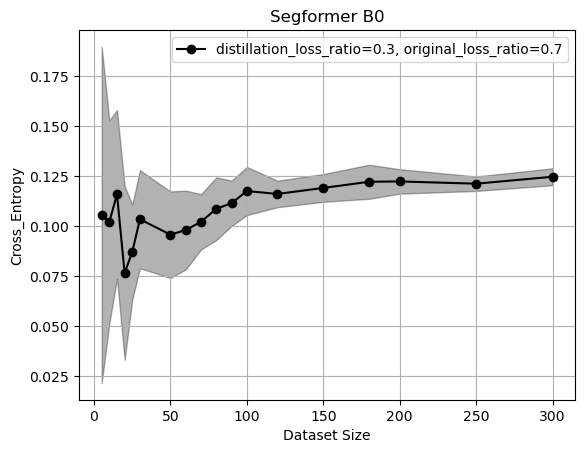

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()